In [60]:
import numpy as np
import netCDF4 as ncdf
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import glob as glob
import os as os
import sys as sys
from filter.RaymondFilters import RaymondFilter6, RaymondFilter10
#from filter import raymond2d_lowpass as RaymondFilter6

# These are 45 vertical levels that the FV3 puts out - use them here to map ARW to that grid for comparison

plevels = np.asarray([100000.,  97500.,  95000.,  92500.,  90000.,  87500.,  85000.,  82500.,
                       80000.,  77500.,  75000.,  72500.,  70000.,  67500.,  65000.,  62500.,
                       60000.,  57500.,  55000.,  52500.,  50000.,  47500.,  45000.,  42500.,
                       40000.,  37500.,  35000.,  32500.,  30000.,  27500.,  25000.,  22500.,
                       20000.,  17500.,  15000.,  12500.,  10000.,   7000.,   5000.,   3000.,
                        2000.,   1000.,    700.,    500.,    200.])
nz_new = plevels.shape[0]

klevel = 5
plevel = plevels[klevel]


print(plevel)


utc = 18

def title_string(time, pres, label, wmax, wmin, eps=None):
    if eps:
        return ("%2.2i UTC %s at Pres=%3.0f mb with EPS=%5.1f \n Wmax: %3.1f        Wmin: %4.2f" % (time, label, pres/100., eps, wmax, wmin))
    else:
        return ("%2.2i UTC %s at Pres=%3.0f mb \n Wmax: %3.1f        Wmin: %4.2f" % (time, label, pres/100., wmax, wmin))

87500.0


In [61]:
f = xr.open_dataset(("/Users/Louis.Wicker/04May2021_HRRR/region.20210504_conus_hrrr.t00z.wrfnatf%2.2i.nc4" % utc))


g = xr.open_dataset("/Users/Louis.Wicker/04May2021_RRFS/mem1/region.t00z.mem01.naf%3.3i.nc4" % utc)



In [62]:
fw_tmp = np.nan_to_num((f.W.values).astype('float64'))
fw_tmp2 = np.zeros_like(fw_tmp)

f.variables['W'][...] = np.nan_to_num(f.W)

gw_tmp = np.nan_to_num((g.W.values).astype('float64'))
gw_tmp2 = np.zeros_like(gw_tmp)

g.variables['W'][...] = np.nan_to_num(g.W)


In [63]:
eps = 50000.

for k in np.arange(klevel-1,klevel+1):
    # fw_tmp2[k] = RaymondFilter6(fw_tmp[k].transpose(),eps).transpose()
    fw_tmp2[k] = RaymondFilter10(fw_tmp[k],eps)
    
fw_tmp2 = f.W.copy(data=(fw_tmp-fw_tmp2))

#

for k in np.arange(klevel-2,klevel+2):
    # gw_tmp2[k] = RaymondFilter6(gw_tmp[k].transpose(),eps).transpose()
    gw_tmp2[k] = RaymondFilter10(gw_tmp[k],eps)

gw_tmp2 = g.W.copy(data=(gw_tmp-gw_tmp2))


RaymondFilter10 called:  Shape of array:  NY: 434  NX:  523
I-loop 0.2423 seconds
J-loop 0.2007 seconds
RaymondFilter10 called:  Shape of array:  NY: 434  NX:  523
I-loop 0.2063 seconds
J-loop 0.2011 seconds
RaymondFilter10 called:  Shape of array:  NY: 556  NX:  641
I-loop 0.3258 seconds
J-loop 0.3235 seconds
RaymondFilter10 called:  Shape of array:  NY: 556  NX:  641
I-loop 0.3180 seconds
J-loop 0.3357 seconds
RaymondFilter10 called:  Shape of array:  NY: 556  NX:  641
I-loop 0.3170 seconds
J-loop 0.3080 seconds
RaymondFilter10 called:  Shape of array:  NY: 556  NX:  641
I-loop 0.3116 seconds
J-loop 0.3148 seconds


Text(0.5, 1.0, '18 UTC RRFS-mem1 High Pass Filter W at Pres=875 mb with EPS=50000.0 \n Wmax: 4.7        Wmin: -3.95')

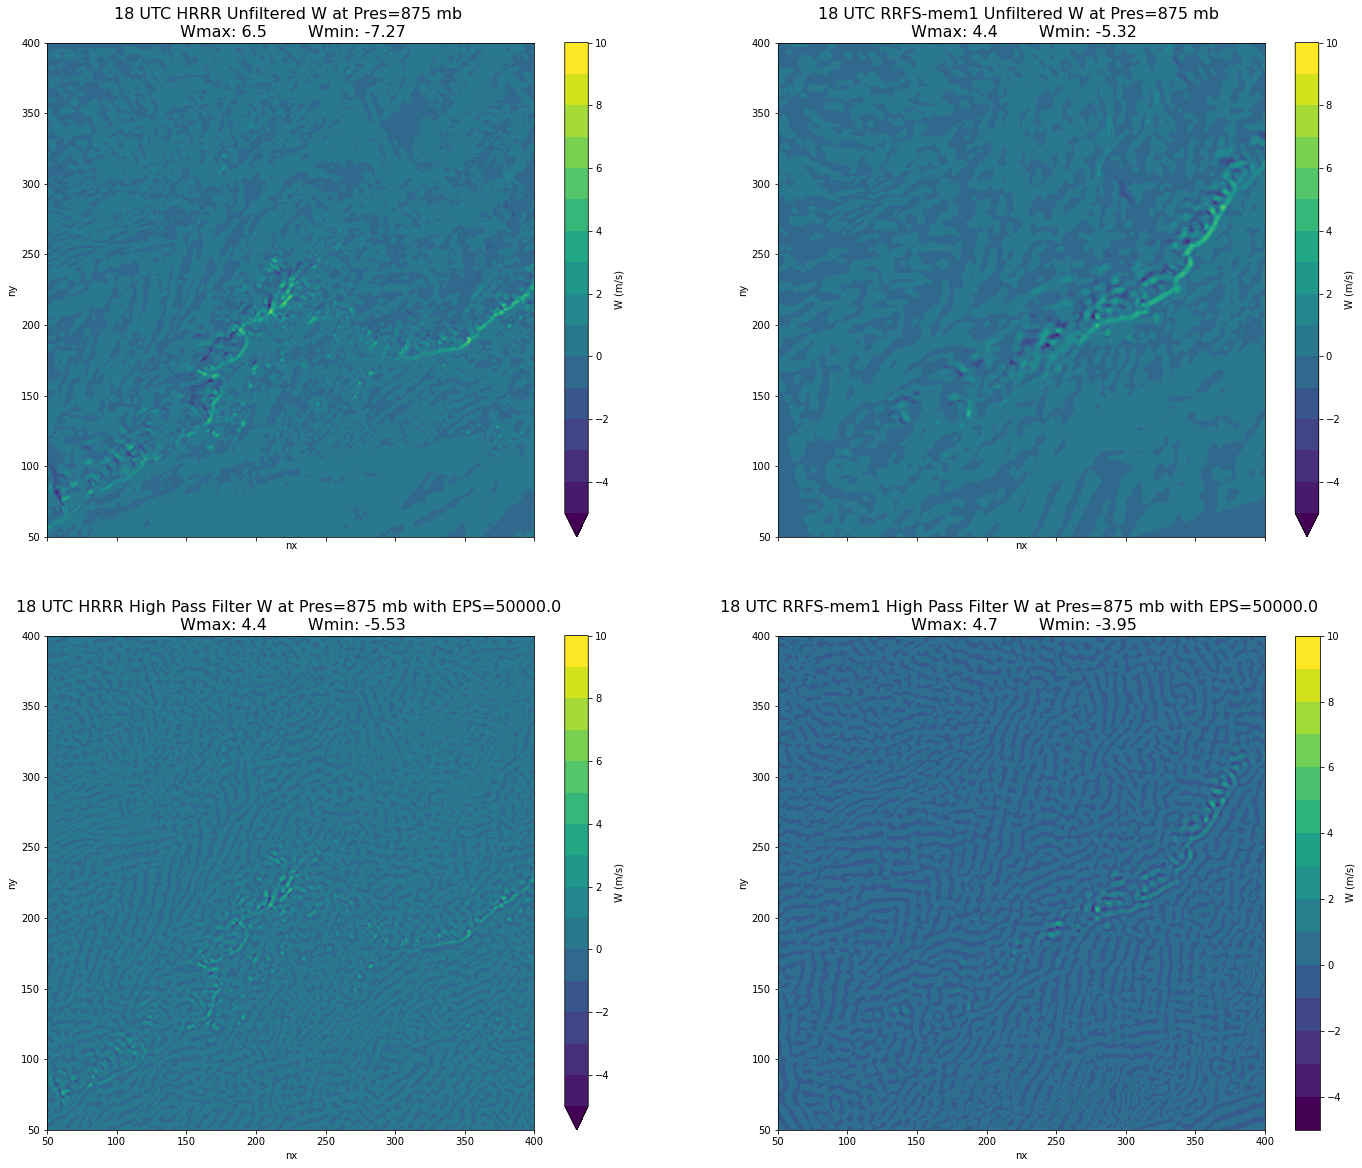

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24,20), sharex=True)
xlim = [50,400]
ylim = [50,400]

colormap = 'viridis'

if klevel < 10:
    vmin = -5.
    vmax = 10.
    clevels = np.linspace(vmin, vmax, 16)
else:
    vmin = -10.
    vmax = 20.
    clevels = np.linspace(vmin, vmax, 16)

# Plot the HRRR data

f.W.isel(nz=klevel).plot.contourf(ax=axes[0,0], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[0,0].set_title(title_string(utc, plevel, 'HRRR Unfiltered W', f.W.isel(nz=klevel).max(), f.W.isel(nz=klevel).min()), fontsize=16)

fw_tmp2.isel(nz=klevel).plot.contourf(ax=axes[1,0], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[1,0].set_title(title_string(utc, plevel, 'HRRR High Pass Filter W', 
                    fw_tmp2.isel(nz=klevel,
                                 nx=np.arange(xlim[0],xlim[1]),
                                 ny=np.arange(ylim[0],ylim[1])).max(),
                    fw_tmp2.isel(nz=klevel,
                                 nx=np.arange(xlim[0],xlim[1]), 
                                 ny=np.arange(ylim[0],ylim[1])).min(), eps=eps), fontsize=16)

g.W.isel(nz=klevel).plot.contourf(ax=axes[0,1], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[0,1].set_title(title_string(utc, plevel, 'RRFS-mem1 Unfiltered W', g.W.isel(nz=klevel, nx=np.arange(0,300)).max(), g.W.isel(nz=klevel).min()), fontsize=16)

gw_tmp2.isel(nz=klevel).plot.contourf(ax=axes[1,1], levels=clevels, xlim=xlim, ylim=ylim, cmap=colormap, cbar_kwargs={'label': 'W (m/s)'})
axes[1,1].set_title(title_string(utc, plevel, 'RRFS-mem1 High Pass Filter W', gw_tmp2.isel(nz=klevel).max(), gw_tmp2.isel(nz=klevel).min(), eps=eps),fontsize=16)
